In [1]:
import numpy as np
import scipy.stats as st
import warnings
import matplotlib.pyplot as plt
import sys
import scipy.integrate as integrate

import OptimalSequence

In [2]:
number_samples = 380

# Generate data
### Using truncnormal 
between 0 and 20 with `mean=8`, `sigma=2`

In [3]:
upper_limit = 20
lower_limit = 0

upper_bound = (upper_limit - 8) / 2
lower_bound = (lower_limit - 8) / 2

mu = 8
sigma = 2

data = st.truncnorm.rvs(lower_bound, upper_bound, loc=8, scale=2, size=number_samples)
print("Bounds: (%3.1f %3.1f) mean=%3.1f; sigma=%3.1f" %(min(data), max(data), np.mean(data), np.std(data)))

Bounds: (1.4 13.5) mean=7.9; sigma=2.0


# Funcion to compute the cost 
### Using TOPtimal to compute the sequence

In [14]:
def compute_cost(cdf, print_sequence=False, limits = [lower_limit, upper_limit]):
    handler = OptimalSequence.TOptimalSequence(limits[0], limits[1], cdf, discret_samples=500)
    sequence = handler.compute_request_sequence()
    if sequence[-1]!=upper_limit:
        sequence[-1] = upper_limit
    arg = [lower_bound, upper_bound]
    if print_sequence:
        print(sequence)

    # Compute the expected makespan (MS)
    MS = sum([sequence[i+1]*(1-st.truncnorm.cdf(sequence[i], loc=mu, scale=sigma, *arg))
              for i in range(len(sequence)-1)])
    MS += sequence[0]
    # MS = sum([sequence[i+1]*cdf(sequence[i]) for i in range(len(sequence)-1)])
    return MS

# Fitting the data using a list of distributions

In [5]:
dist_list = [        
            st.alpha,st.beta,st.cosine,st.dgamma,st.dweibull,st.exponnorm,st.exponweib,
            st.exponpow,st.genpareto,st.gamma,st.halfnorm,st.invgauss,st.invweibull,
            st.laplace,st.loggamma,st.lognorm,st.lomax,st.maxwell,st.norm,st.pareto,
            #st.pearson3,
            st.rayleigh,st.rice,st.truncexpon,st.truncnorm,st.uniform,
            st.weibull_min,st.weibull_max
        ]

In [6]:
best_fit = [np.inf, 0, 0, 0, [0, 0, 0]]
worse_fit = [0, 0, 0, 0, [0, 0, 0]]
sys.stdout.write("[")
for i in range(100):
    data = st.truncnorm.rvs(lower_bound, upper_bound, loc=mu, scale=sigma, size=number_samples)

    # Best holders
    best_distribution = -1
    best_params = (0.0, 1.0)
    best_sse = np.inf
    best_cost = -1

    norm_distribution = []
    truncnorm_distribution = []

    # Estimate distribution parameters from data
    for distribution in dist_list:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Compute the histogram for the data
                y, x = np.histogram(data, bins=100, density=True)
                x = (x + np.roll(x, -1))[:-1] / 2.0

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                if distribution.name == "norm" or distribution.name == "truncnorm":
                    arg = params[:-2]
                    cdf = lambda val: distribution.cdf(val, loc=params[-2], scale=params[-1], *arg)
                    cost = compute_cost(cdf)
                    
                if distribution.name == "norm":
                    norm_distribution = [sse, params, cost]

                if distribution.name == "truncnorm":
                    truncnorm_distribution = [sse, params, cost]

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    arg = best_params[:-2]
    cdf = lambda val: best_distribution.cdf(val, loc=best_params[-2], scale=best_params[-1], *arg)
    best_cost = compute_cost(cdf)
            
    if np.abs(best_cost - norm_distribution[2]) < np.abs(best_fit[0] - best_fit[4][2]) and best_distribution.name != "norm":
        best_fit = [best_cost, best_sse, best_distribution, best_params, norm_distribution]
    if np.abs(best_cost - norm_distribution[2]) > np.abs(worse_fit[0] - worse_fit[4][2]):
        worse_fit = [best_cost, best_sse, best_distribution, best_params, norm_distribution]
    sys.stdout.write("=")

sys.stdout.write("]\n")

[=====================================================================================

/opt/conda/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1420: RuntimeWarning: overflow encountered in exp
  return _norm_cdf(x) - np.exp(expval) * _norm_cdf(x - invK)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1420: RuntimeWarning: invalid value encountered in multiply
  return _norm_cdf(x) - np.exp(expval) * _norm_cdf(x - invK)


===============]


# Plot data
### worse and best fit compared to the norm fit
* the best fit and 
* the norm distributions

Best fit cost 11.938229 
Norm cost 11.938229 (diff 0.000000)


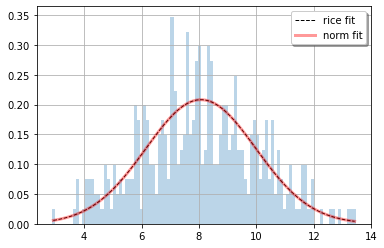

In [7]:
# Best fit

print("Best fit cost %f \nNorm cost %f (diff %f)" %(best_fit[0], best_fit[4][2], best_fit[0]-best_fit[4][2]))
fig, ax = plt.subplots(1, 1)
# plot the best fit line
best_distribution = best_fit[2]
best_params = best_fit[3]
ax.plot(x, best_distribution.pdf(x, loc=best_params[-2], scale=best_params[-1], *best_params[:-2]),
        'k--', lw=1, alpha=1.0, label='%s fit' %(best_distribution.name))
# plot the normal line
ax.plot(x, st.norm.pdf(x, *best_fit[4][1]),
        'r-', lw=3, alpha=0.4, label='norm fit')
ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.grid(True)

plt.show()

Worse fit cost 19.833439 
Norm cost 11.942365 (diff 7.891074)

rice sequence:[5.48, 8.040000000000001, 10.08, 11.84, 13.44, 14.92, 16.28, 17.56, 18.8, 19.8, 19.96, 20.0]
norm sequence:[10.92, 13.6, 15.68, 17.48, 19.080000000000002, 19.96, 20.0]


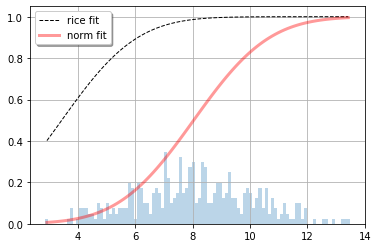

In [8]:
# Worse fit

print("Worse fit cost %f \nNorm cost %f (diff %f)\n" %(worse_fit[0], worse_fit[4][2], worse_fit[0]-worse_fit[4][2]))
worse_distribution = worse_fit[2]
worse_params = worse_fit[3]

sys.stdout.write(worse_distribution.name+" sequence:")
arg = worse_params[:-2]
cdf = lambda val: worse_distribution.cdf(val, loc=worse_params[-2], scale=worse_params[-1], *arg)
worse_cost = compute_cost(cdf, print_sequence=True)

sys.stdout.write("norm sequence:")
arg = worse_fit[4][1][:-2]
cdf = lambda val: st.norm.cdf(val, loc=worse_fit[4][1][-2], scale=worse_fit[4][1][-1], *arg)
worse_cost = compute_cost(cdf, print_sequence=True)


fig, ax = plt.subplots(1, 1)
# plot the best fit line
ax.plot(x, worse_distribution.cdf(x, loc=worse_params[-2], scale=worse_params[-1], *worse_params[:-2]),
        'k--', lw=1, alpha=1.0, label='%s fit' %(worse_distribution.name))
# plot the normal line
ax.plot(x, st.norm.cdf(x, *worse_fit[4][1]),
        'r-', lw=3, alpha=0.4, label='norm fit')
ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.grid(True)

plt.show()

# Documenting python limitations

The PDF fits the data well (close to the norm distribution), however:

### Pearson 3 distribution
When the skew parameter is negative, the CDF is decreasing from 1 to 0

### Rice distribution
In some cases, the CDF is 1 for all values

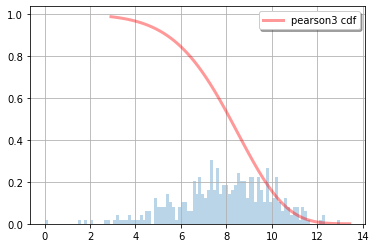

0.9993400724474001


True

In [9]:
data = st.pearson3.rvs(-0.5, loc=8, scale=2, size=number_samples)
fig, ax = plt.subplots(1, 1)
ax.plot(x, st.pearson3.cdf(x, -0.5, loc=8, scale=2),
        'r-', lw=3, alpha=0.4, label='pearson3 cdf')
ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.grid(True)

plt.show()
print(st.pearson3.cdf(0, -0.5, loc=8, scale=2))
np.isclose(st.pearson3.cdf(0, -0.5, loc=8, scale=2), 1, rtol=1e-03)

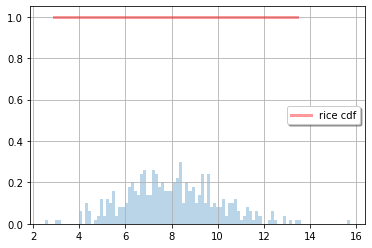

1.000000000003714


In [10]:
data = st.rice.rvs(160, loc=-312, scale=2, size=number_samples)
fig, ax = plt.subplots(1, 1)
ax.plot(x, st.rice.cdf(x, 160, loc=-312, scale=2),
        'r-', lw=3, alpha=0.4, label='rice cdf')
ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.grid(True)

plt.show()
print(st.rice.cdf(0, 160, loc=-312, scale=2))

# Polynomial fit

In [11]:
def get_cdf(start, x, params):
    return integrate.quad(np.poly1d(params), start, x, epsrel=1.49e-05)[0]

In [15]:
data = st.truncnorm.rvs(lower_bound, upper_bound, loc=mu, scale=sigma, size=number_samples)
y, x = np.histogram(data, bins=100, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
best_err = np.inf
best_z = -1
for order in range(1,6):
    with warnings.catch_warnings():
        warnings.simplefilter("error")
        try:
            z = np.polyfit(x, y, order)
        except:
            break

        err = np.sum((np.polyval(z, x) - y)**2)
        if err < best_err:
            best_order = order
            best_z = z
            best_err = err

cdf = lambda val: get_cdf(x[0], val, best_z)
cost = compute_cost(cdf, limits=[x[0], x[-1]])
print("Polynomial Order", best_order, best_z)
print("Cost", cost)

Polynomial Order 5 [ 5.76203368e-05 -1.76780186e-03  1.79537505e-02 -6.68584047e-02
  7.46225364e-02  4.03327358e-02]
Cost 11.99962040632441


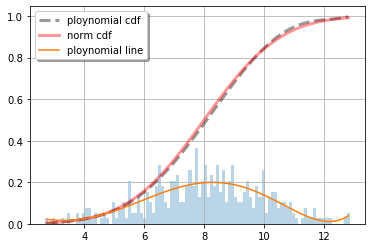

In [16]:
#print([cdf(i) for i in x])
fig, ax = plt.subplots(1, 1)
ax.plot(x, [cdf(i) for i in x], 'k--', lw=3, alpha=0.4, label='ploynomial cdf')
ax.plot(x, st.norm.cdf(x, loc=mu, scale=sigma),
        'r-', lw=3, alpha=0.4, label='norm cdf')

ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3)
ax.plot(x, np.polyval(z, x), label='ploynomial line')
ax.legend(shadow=True)
plt.grid(True)

plt.show()